In [1]:
import pandas as pd
import numpy as np

column_names = ["user_id", "item_id", "rating", "timestamp"]

df = pd.read_csv("ml-100k/u.data", sep="\t", names=column_names)

In [2]:
df.head(3)
#user_id and item_id are nominal data (categoric), rating is ordinal data (categoric) and timestamp is continous data (numeric)

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116


In [3]:
#All integers
df.dtypes

user_id      int64
item_id      int64
rating       int64
timestamp    int64
dtype: object

In [4]:
#4 columns and 100000 rows
df.shape

(100000, 4)

In [5]:
#There are no null values
df.isna().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

In [6]:
#Convert timestamp
from datetime import date

df["new_date"] = df["timestamp"].apply(lambda x: date.fromtimestamp(x))

df.head(3)

,user_id,item_id,rating,timestamp,new_date
0,196,242,3,881250949,1997-12-04
1,186,302,3,891717742,1998-04-04
2,22,377,1,878887116,1997-11-07


In [7]:
#Drop timestamp column
df.drop(columns=["timestamp"], inplace=True)

In [8]:
df.head(3)

,user_id,item_id,rating,new_date
0,196,242,3,1997-12-04
1,186,302,3,1998-04-04
2,22,377,1,1997-11-07


C:\Users\omerf\AppData\Local\Temp\ipykernel_20848\7338068.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x = "rating" , data=df, palette="coolwarm")


<Axes: title={'center': 'Number of Movies by Their Rating'}, xlabel='Rating', ylabel='Count'>

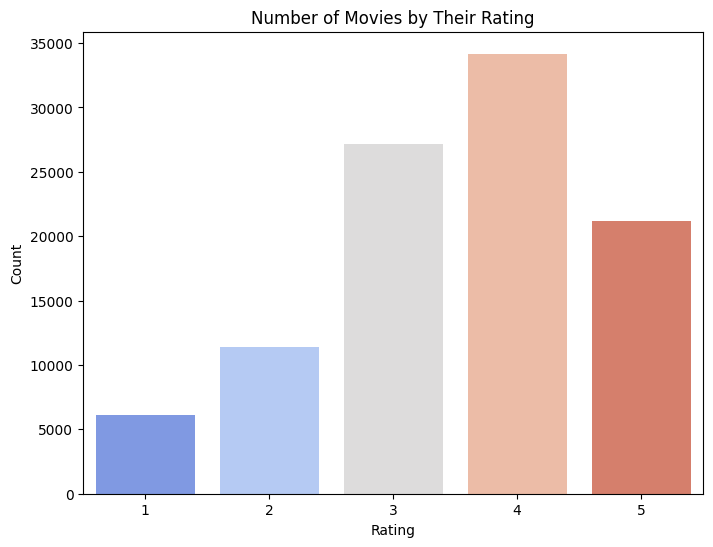

In [9]:
#A graph for fun
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.title("Number of Movies by Their Rating")
plt.xlabel("Rating")
plt.ylabel("Count")
sns.countplot(x = "rating" , data=df, palette="coolwarm")


#Most of the movies have 4 ratings

In [10]:
#Split dataset into training and test sets
from sklearn.model_selection import train_test_split

X = df[["user_id", "item_id"]]
y = df["rating"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Model Review

I read these 2 articles on Medium to get started, explains item-based and user-based collaborative filtering in a simple way - https://medium.com/@cfpinela/recommender-systems-user-based-and-item-based-collaborative-filtering-5d5f375a127f , https://medium.com/@iremcilingir/%C3%B6neri-sistemleri-recommendation-systems-28a3f341c0a9

After that I read this article for further explanation - https://onlinelibrary.wiley.com/doi/full/10.1155/2009/421425

For matrix factorization I read this post on Medium - https://towardsdatascience.com/recommendation-system-matrix-factorization-d61978660b4b




1 - User-Based Collaborative Filtering

In [11]:
#Importing KNN for this task and metrics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, ndcg_score, top_k_accuracy_score

best = []
def best_k():
    for k in range(1,50):
        neighbor = KNeighborsClassifier(n_neighbors=k)
        neighbor.fit(x_train,y_train)
        prediction = neighbor.predict(x_test)
        recall = precision_score(y_test,prediction,average="weighted")
        best.append(recall)
best_k()

<Axes: >

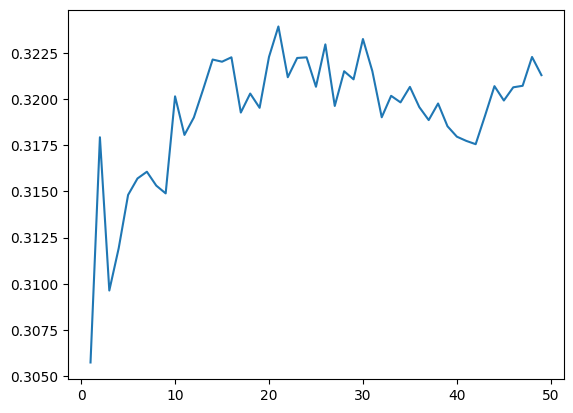

In [ ]:
sns.lineplot(y=best, x = range(1,50))
#k = 21 is the best

In [ ]:
neighbor = KNeighborsClassifier(n_neighbors=21)
neighbor.fit(x_train,y_train)
prediction = neighbor.predict(x_test)

In [ ]:
print(f"Recall score is : {recall_score(y_test,prediction, average="weighted"):.4f}")
print(f"Precision score is : {precision_score(y_test,prediction, average="weighted"):.4f}")

Recall score is : 0.3398
Precision score is : 0.3239


In [ ]:
#I think recall and hit ratio are the same thing
def hit_ratio(y_test, prediction):
    hits = sum(1 for true, pred in zip(y_test, prediction) if true == pred)
    return hits / len(y_test)

hit_ratio_value = hit_ratio(y_test, prediction)
print(f'Hit Ratio: {hit_ratio_value:.4f}')

Hit Ratio: 0.3398


In [ ]:
y_test = np.array(y_test)
prediction = np.array(prediction)

In [ ]:
#I couldn't do it with sklearn ndcg so I used this code from internet
def dcg_score(y_true, y_score, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    gains = 2 ** y_true - 1
    discounts = np.log2(np.arange(2, y_true.size + 2))
    return np.sum(gains / discounts)

def ndcg_score(y_true, y_score, k=21):
    best_dcg = dcg_score(y_true, y_true, k)
    actual_dcg = dcg_score(y_true, y_score, k)
    return actual_dcg / best_dcg if best_dcg > 0 else 0

k = 21
ndcg_value = ndcg_score(y_test, prediction, k)
print(f'NDCG score is: {ndcg_value:.4f}')

NDCG score is: 0.4949
